##### **Amazon Product Review Sentiment Analysis - Video Games Sector** #####

This notebook uses dataset from Amazon Review Data - video games (2018) : https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/ 'small' subsets of video games 5-core. 

In [4]:
!pip install textblob


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
#Import Libraries
#Data manipulation / visual libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from autogluon.tabular import TabularPredictor

#Text processing libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob  

# Download NLTK stopwords
nltk.download('punkt')
nltk.download('stopwords')

#Train and Split Libraries
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /Users/j_j/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/j_j/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
#Json file dataset - Amazon Video Games
df = pd.read_json('Video_Games.json', lines = True)


In [3]:
#Overview of the data
print(df.head())

   overall  verified   reviewTime      reviewerID        asin  \
0        5      True  10 17, 2015  A1HP7NVNPFMA4N  0700026657   
1        4     False  07 27, 2015  A1JGAP0185YJI6  0700026657   
2        3      True  02 23, 2015  A1YJWEXHQBWK2B  0700026657   
3        2      True  02 20, 2015  A2204E1TH211HT  0700026657   
4        5      True  12 25, 2014  A2RF5B5H74JLPE  0700026657   

        reviewerName                                         reviewText  \
0        Ambrosia075  This game is a bit hard to get the hang of, bu...   
1             travis  I played it a while but it was alright. The st...   
2  Vincent G. Mezera                                           ok game.   
3         Grandma KR  found the game a bit too complicated, not what...   
4                jon  great game, I love it and have played it since...   

                                       summary  unixReviewTime vote style  \
0                  but when you do it's great.      1445040000  NaN   NaN   
1  B

In [8]:
#Data info 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         497577 non-null  int64 
 1   verified        497577 non-null  bool  
 2   reviewTime      497577 non-null  object
 3   reviewerID      497577 non-null  object
 4   asin            497577 non-null  object
 5   reviewerName    497501 non-null  object
 6   reviewText      497419 non-null  object
 7   summary         497468 non-null  object
 8   unixReviewTime  497577 non-null  int64 
 9   vote            107793 non-null  object
 10  style           289237 non-null  object
 11  image           3634 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 42.2+ MB
None


Roughly, over 497,000 entries with a combination of int, string and boolean data types. 

In [9]:
#Column Names
df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image'],
      dtype='object')

Dataset inclues overall (rating), verified, reviewtime, reviewerId, asin, reviwername, reviewtext, summary, unixreviewtime, vote, style and image.

In [10]:
print(df['overall'].describe())

count    497577.000000
mean          4.220456
std           1.185424
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64


The above is a statistics for rating in a scale from 1 to 5. On average, the rating scored at 4.22, showing a general positive sentiment on reviews. Considering 25% percentile at 4.0 and 75% at 5.0, the review is generally positive.

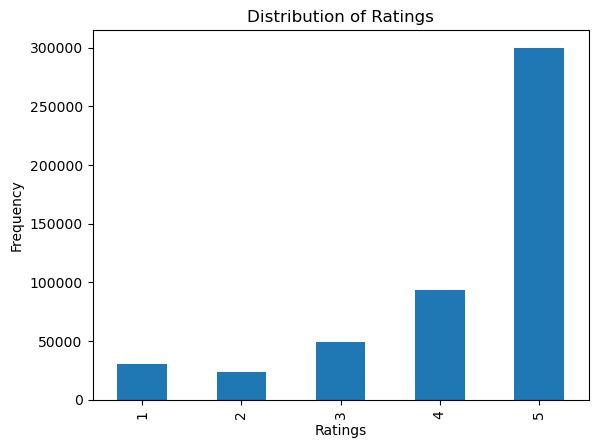

In [11]:
df['overall'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()

In [12]:
#Checking for null values
df.isnull().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          76
reviewText           158
summary              109
unixReviewTime         0
vote              389784
style             208340
image             493943
dtype: int64

The data contains a lot of missing values so we'll be preprocessing them before use.

In [13]:
#Counting the overall columns
print(df['overall'].value_counts())

overall
5    299759
4     93654
3     49146
1     30883
2     24135
Name: count, dtype: int64


In [14]:
#replacing nan values with an empty string.
#calculating for length of the texts
df['reviewText'] = df['reviewText'].fillna('')
df['review_length'] = df['reviewText'].apply(len)

#descriptive statistics for review length
print(df['review_length'].describe())


count    497577.000000
mean        670.075799
std        1265.977511
min           0.000000
25%          57.000000
50%         210.000000
75%         710.000000
max       32721.000000
Name: review_length, dtype: float64


In [15]:
#Sample of the review text
for review in df['reviewText'].sample(50):
    print(review)
    print("------")

I have to say PS3 is by far the best console ever created, I don't even know how people even consider having a Xbox, Wii I can understand, but PS3's 1080P resolution on a big screen Sony HD TV is unbeatable. I'm saying these things because this is a must have game for your PS3. This game looks very pretty, the images and colors are gorgeous and it really makes you appreciate your console.

I love fighting games and I have to say most fighting games are best played with the D-Pad as opposed of the analog joystick. For example with Super Street Fighter IV Arcade Edition it is so hard to play with the joystick. This one is the other way around. I have been playing fighting games with the D-Pad since the 90s, and other than Tekken 5 Dark Resurrection I never thought I would love playing a game with the joystick, KOF XIII responds so well to the joystick that it becomes addictive. Even better is having an arcade stick controller to have the full game experience.

Another great thing about t

**Labeling Sentiment Analysis**

In [16]:
#Labeling for sentiment analysis 
def sentiment_label(row):
    if row['overall'] <= 2:
        return 'negative'
    elif row['overall'] == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df.apply(sentiment_label, axis = 1)

Since we have overall column from 1-5, we'll rate negative if below 2, neutral if 3 and positive if 4,5.

**Data Cleaning**

In [17]:
#Creating function to clean text
def clean_text(text):
    #remove non-alphabetic words / characters and convert to lower case
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    #tokensize and remove stop words
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)#spacing in between tokens

# applying clean_text function to review_text
df['cleaned_reviewText'] = df['reviewText'].fillna('').apply(clean_text)

In [18]:
#Counting for sentiment columns.
print(df['sentiment'].value_counts())


sentiment
positive    393413
negative     55018
neutral      49146
Name: count, dtype: int64


Positive rating over others so we need to even it out for model to work well. We will undersample positive values to the minimum of the 3, neutral - 49,146.

Before undersampling, I have added a step for validation of process and model, TextBlob sentiment analysis for 

In [19]:
# Textblob Sentiment Analysis
def analyze_sentiment_textblob(text):
    testimonial = TextBlob(text)
    polarity = testimonial.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_textblob'] = df['reviewText'].apply(analyze_sentiment_textblob)


In [23]:
# Calculate the total number of reviews
total_reviews = len(df)

# Calculate agreement and disagreement counts
agreement_count = (df['sentiment'] == df['sentiment_textblob']).sum()
disagreement_count = total_reviews - agreement_count

# Calculate the ratio
agreement_ratio = agreement_count / total_reviews
disagreement_ratio = disagreement_count / total_reviews

print(f"Total Reviews: {total_reviews}")
print(f"Agreement Count: {agreement_count}")
print(f"Disagreement Count: {disagreement_count}")
print(f"Agreement Ratio: {agreement_ratio:.2f}")
print(f"Disagreement Ratio: {disagreement_ratio:.2f}")

Total Reviews: 497577
Agreement Count: 359195
Disagreement Count: 138382
Agreement Ratio: 0.72
Disagreement Ratio: 0.28


Comparison of Sentiments:
   sentiment sentiment_textblob
0   positive           positive
1   positive           positive
2    neutral           positive
3   negative           negative
4   positive           positive
5   positive           positive
6   negative           negative
7   positive           negative
8   positive           positive
9   positive           positive
10  positive           negative
11  negative           negative
12  positive           positive
13  positive           positive
14  positive           negative
15  positive           positive
16  positive           positive
17  negative           positive
18  negative           positive
19  positive           positive


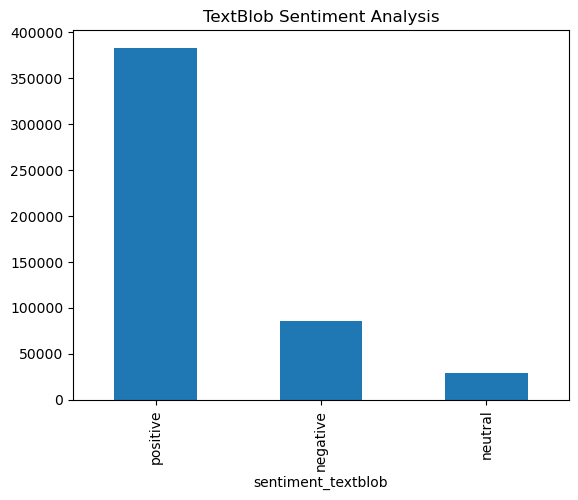

In [20]:
# Comparing Sentiment Analysis
print("Comparison of Sentiments:")
print(df[['sentiment', 'sentiment_textblob']].head(20))

# Visualizing Sentiment Analysis
df['sentiment_textblob'].value_counts().plot(kind='bar', title='TextBlob Sentiment Analysis')
plt.show()


In [24]:
# Calculate agreement and disagreement counts
agreement_count = (df['sentiment'] == df['sentiment_textblob']).sum()
total_reviews = len(df)

# Calculate the agreement ratio
agreement_ratio = agreement_count / total_reviews

# Print the ratio
print(f"Agreement Ratio: {agreement_ratio:.2f}")

Agreement Ratio: 0.72


We conducted textblob and overall rating validation. Total review = 497,577, agreement count = 359,195, disagreement count = 138,382. We have a 72% agreement ratio between the two methods which is a relatively high level of consistency between two methods. In 72% of the cases, the method classifies as positive, neutral, or negative sentiment aligning with TextBlob's classification. In 28% of the reviews, there is a discrepancy between two methods. This could be due to various factors, such as difference in how each method interprets the sentiment conveyed in the text, overall = by human, and text blob by machine learning model.

This agreement suggests the method of using the 'overall' rating as a basis for sentiment analysis is largely in line with the automated, NLP based apporach of Textblob. Disagreement also might be worth seeing as the limitations and differences in each method is there. It could provide insights into certain nuances or complexities in text sentiment that might not be captured uniformly by both methods.

As with the high agreement ratio, I will continue with using the overall column as a basis for analysis. 

In [21]:
#Counting the minimum for sentiment column.
minority_class_size = min(df['sentiment'].value_counts())

print(minority_class_size)

49146


In [29]:
#Separating the values for sentiment
df_negative = df[df['sentiment'] == 'negative']
df_neutral = df[df['sentiment'] == 'neutral']
df_positive = df[df['sentiment'] == 'positive']

#Undersample positive number
df_positive_undersampled = df_positive.sample(n=minority_class_size, random_state= 100)

#Combining undersampled one with other classes
balanced_df = pd.concat([df_negative, df_neutral, df_positive_undersampled])

We undersampled  the positive values and have a balanced dataset.

In [30]:
balanced_df = balanced_df.sample(frac=1, random_state=150).reset_index(drop=True)


In [32]:
#Reverifying the count for sentiment
print(balanced_df['sentiment'].value_counts())


sentiment
negative    55018
neutral     49146
positive    49146
Name: count, dtype: int64


We will now move onto training the model.

**Training the model**

In [33]:
#Test and train split - 8:2
X_train, X_test, y_train, y_test = train_test_split(balanced_df['cleaned_reviewText'], balanced_df['sentiment'], test_size=0.2, random_state=42)


Split the data into test and train on train: 80%, test: 20%

In [45]:
#Combine features and labels into one dataFrame for training and test
train_data = pd.DataFrame({'cleaned_reviewText': X_train, 'sentiment': y_train})
test_data = pd.DataFrame({'cleaned_reviewText': X_test, 'sentiment': y_test})


Using AutoML for the model - autogloun 

In [43]:
#Applying autogluon for prediction
predictor = TabularPredictor(label='sentiment', eval_metric='accuracy')
predictor.fit(train_data=train_data, tuning_data=tuning_data, time_limit=3600)

No path specified. Models will be saved in: "AutogluonModels/ag-20231217_095451"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20231217_095451"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.11.5
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.1.0: Mon O

[1000]	valid_set's multi_error: 0.325713
[2000]	valid_set's multi_error: 0.32069
[3000]	valid_set's multi_error: 0.317885
[4000]	valid_set's multi_error: 0.318635


	0.6829	 = Validation score   (accuracy)
	82.38s	 = Training   runtime
	6.2s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 3384.36s of the 3384.36s of remaining time.


[1000]	valid_set's multi_error: 0.318994
[2000]	valid_set's multi_error: 0.314004
[3000]	valid_set's multi_error: 0.312895
[4000]	valid_set's multi_error: 0.312798
[5000]	valid_set's multi_error: 0.310286
[6000]	valid_set's multi_error: 0.30908
[7000]	valid_set's multi_error: 0.308264
[8000]	valid_set's multi_error: 0.309569
[9000]	valid_set's multi_error: 0.308786


	0.6921	 = Validation score   (accuracy)
	149.52s	 = Training   runtime
	10.92s	 = Validation runtime
Fitting model: RandomForestGini ... Training model for up to 3223.33s of the 3223.32s of remaining time.
	0.6551	 = Validation score   (accuracy)
	102.04s	 = Training   runtime
	1.16s	 = Validation runtime
Fitting model: RandomForestEntr ... Training model for up to 3119.68s of the 3119.67s of remaining time.
	0.6582	 = Validation score   (accuracy)
	96.49s	 = Training   runtime
	1.05s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 3021.71s of the 3021.7s of remaining time.
		
Fitting model: ExtraTreesGini ... Training model for up to 3021.03s of the 3021.03s of remaining time.
	0.6626	 = Validation score   (accuracy)
	114.9s	 = Training   runtime
	1.16s	 = Validation runtime
Fitting model: ExtraTreesEntr ... Training model for up to 2904.53s of the 2904.52s of remaining time.
	0.6639	 = Validation score   (accuracy)
	113.92s	 = Training   runtime
	1.19s	 = 

The result suggests training data accuracy is 0.92 with validation score of 0.6921. The model used to train the dataset are light GBM, random forest, catboost, extrat tress, xgboost and a weighted ensemble model which suggests, L@ achieved the highest validation score of 0.6964. 



In [47]:
#Prediction on test data
performance = predictor.evaluate(test_data)

**Results**

In [48]:
print(performance)

{'accuracy': 0.6963668384319353, 'balanced_accuracy': 0.6947992617879332, 'mcc': 0.5443940057118994}


In [54]:
train_performance = predictor.evaluate(train_data)
print(train_performance)

{'accuracy': 0.9227790098493249, 'balanced_accuracy': 0.921701327127947, 'mcc': 0.885098580392552}


In [49]:
#Classification report prep 
#On training data
y_train_pred = predictor.predict(train_data.drop(columns=['sentiment']))

#On test data
y_test_pred = predictor.predict(test_data.drop(columns=['sentiment']))


In [50]:
#Classification report for training data
train_report = classification_report(train_data['sentiment'], y_train_pred)
print("Classification Report for training data:\n", train_report)

#Classification report for test data
test_report = classification_report(test_data['sentiment'], y_test_pred)
print("\nClassification Report for test data:\n", test_report)


Classification Report for Training Data:
               precision    recall  f1-score   support

    negative       0.93      0.95      0.94     44149
     neutral       0.96      0.86      0.91     39178
    positive       0.89      0.96      0.92     39321

    accuracy                           0.92    122648
   macro avg       0.92      0.92      0.92    122648
weighted avg       0.92      0.92      0.92    122648


Classification Report for Test Data:
               precision    recall  f1-score   support

    negative       0.72      0.76      0.74     10869
     neutral       0.63      0.56      0.60      9968
    positive       0.73      0.76      0.75      9825

    accuracy                           0.70     30662
   macro avg       0.69      0.69      0.69     30662
weighted avg       0.69      0.70      0.69     30662



Classification report came out with an accuracy 0.92 with prediction and recall values high across all classes in training dataset. This indicates the model is effective at identifying correct sentiments and has a low rate of false positive and false negatives. High F1 Scores which balance precision and recall are also high which suggests a well-balanced performance between identifying relevant instances.

Test data classification accuracy of 0.70 is a moderate value in precision and recall with balanced performance across classes. 


In summary, the generalization gap in performance between the training and test data suggests the overfitting issue where the training data may not capture the details in training data. The neutral class is slightly lower compared to negative and positive. This is a possibility due to inherent difficulties in distinguishing neutral sentiment in the data. 